In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

df_train = pd.read_csv('./../data/processed/train_woe_features.csv')
df_valid = pd.read_csv('./../data/processed/valid_woe_features.csv')

feature_cols = ['int_rate_woe', 'fico_range_low_woe', 'dti_woe', 'annual_inc_woe',
                'loan_amnt_woe', 'inq_last_6mths_woe', 'revol_util_woe',
                'term_woe', 'grade_woe', 'home_woe']

X_train = df_train[feature_cols].values
y_train = df_train['default'].values

X_valid = df_valid[feature_cols].values
y_valid = df_valid['default'].values

print(f"Training: {len(X_train):,} samples")
print(f"Validation: {len(X_valid):,} samples")
print(f"Features: {len(feature_cols)}")

Training: 668,181 samples
Validation: 168,699 samples
Features: 10


In [2]:
try:
    import pymc as pm
    import arviz as az
    print("PyMC loaded successfully")
    print(f"PyMC version: {pm.__version__}")
except ImportError:
    print("PyMC not installed. Installing now...")
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pymc", "arviz"])
    import pymc as pm
    import arviz as az
    print("PyMC installed and loaded")

PyMC not installed. Installing now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 17.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 51.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15/15 [pymc]2m14/15 [pymc]sor]n]tats]
PyMC installed and loaded


In [3]:
sample_size = 50000

np.random.seed(42)
sample_indices = np.random.choice(len(X_train), size=sample_size, replace=False)

X_train_sample = X_train[sample_indices]
y_train_sample = y_train[sample_indices]

print(f"Using sample of {sample_size:,} loans for Bayesian inference")
print(f"Default rate in sample: {y_train_sample.mean():.2%}")

Using sample of 50,000 loans for Bayesian inference
Default rate in sample: 21.19%


In [4]:
print("Building Bayesian model...")

with pm.Model() as bayesian_model:
    
    beta = pm.Normal('beta', mu=0, sigma=2, shape=X_train_sample.shape[1])
    alpha = pm.Normal('alpha', mu=0, sigma=2)
    
    logit_p = alpha + pm.math.dot(X_train_sample, beta)
    
    y_obs = pm.Bernoulli('y_obs', logit_p=logit_p, observed=y_train_sample)
    
    print("Model defined")
    print("\nStarting MCMC sampling (this will take 5-10 minutes)...")
    
    trace = pm.sample(2000, tune=1000, cores=1, random_seed=42, 
                      progressbar=True, return_inferencedata=True)
    
print("\nSampling complete!")

Initializing NUTS using jitter+adapt_diag...


Building Bayesian model...
Model defined

Starting MCMC sampling (this will take 5-10 minutes)...


Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 185 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Sampling complete!


In [5]:
print("Convergence Diagnostics:")
print("\nR-hat values (should be close to 1.0):")

summary = az.summary(trace, var_names=['alpha', 'beta'])
print(summary[['mean', 'sd', 'r_hat']])

print("\nR-hat interpretation:")
print("  < 1.01: Excellent convergence")
print("  < 1.05: Good convergence")
print("  > 1.05: Poor convergence (need more samples)")

Convergence Diagnostics:

R-hat values (should be close to 1.0):
          mean     sd  r_hat
alpha   -1.529  0.022    1.0
beta[0] -0.659  0.058    1.0
beta[1] -0.464  0.040    1.0
beta[2] -0.574  0.043    1.0
beta[3] -0.453  0.078    1.0
beta[4] -0.587  0.083    1.0
beta[5] -0.405  0.059    1.0
beta[6]  0.193  0.093    1.0
beta[7]  0.569  0.031    1.0
beta[8]  0.025  0.056    1.0
beta[9]  1.173  0.084    1.0

R-hat interpretation:
  < 1.01: Excellent convergence
  < 1.05: Good convergence
  > 1.05: Poor convergence (need more samples)


In [6]:
print("Making predictions with uncertainty...")

posterior_samples = trace.posterior

alpha_samples = posterior_samples['alpha'].values.flatten()
beta_samples = posterior_samples['beta'].values.reshape(-1, X_train_sample.shape[1])

n_posterior_samples = len(alpha_samples)
print(f"Using {n_posterior_samples} posterior samples")

n_predictions = 1000
sample_indices = np.random.choice(n_posterior_samples, size=n_predictions, replace=False)

predictions_valid = np.zeros((len(X_valid), n_predictions))

for i in range(n_predictions):
    idx = sample_indices[i]
    alpha_i = alpha_samples[idx]
    beta_i = beta_samples[idx]
    
    logit = alpha_i + np.dot(X_valid, beta_i)
    prob = 1 / (1 + np.exp(-logit))
    predictions_valid[:, i] = prob
    
    if (i + 1) % 200 == 0:
        print(f"  Completed {i+1}/{n_predictions} predictions")

print("\nPredictions complete!")

Making predictions with uncertainty...
Using 4000 posterior samples
  Completed 200/1000 predictions
  Completed 400/1000 predictions
  Completed 600/1000 predictions
  Completed 800/1000 predictions
  Completed 1000/1000 predictions

Predictions complete!


In [7]:
pred_mean = predictions_valid.mean(axis=1)
pred_std = predictions_valid.std(axis=1)
pred_lower = np.percentile(predictions_valid, 2.5, axis=1)
pred_upper = np.percentile(predictions_valid, 97.5, axis=1)

auc_bayesian = roc_auc_score(y_valid, pred_mean)
gini_bayesian = 2 * auc_bayesian - 1

print("Bayesian Model Performance:")
print(f"  AUC: {auc_bayesian:.4f}")
print(f"  Gini: {gini_bayesian:.4f}")

print(f"\nUncertainty Statistics:")
print(f"  Mean prediction: {pred_mean.mean():.2%}")
print(f"  Mean std dev: {pred_std.mean():.4f}")
print(f"  Mean interval width: {(pred_upper - pred_lower).mean():.4f}")

df_uncertainty = pd.DataFrame()
df_uncertainty['pred_mean'] = pred_mean
df_uncertainty['pred_std'] = pred_std
df_uncertainty['pred_lower'] = pred_lower
df_uncertainty['pred_upper'] = pred_upper
df_uncertainty['true_default'] = y_valid

df_uncertainty.to_csv('./../data/processed/bayesian_predictions.csv', index=False)
print("\nUncertainty predictions saved")

Bayesian Model Performance:
  AUC: 0.6966
  Gini: 0.3933

Uncertainty Statistics:
  Mean prediction: 22.29%
  Mean std dev: 0.0060
  Mean interval width: 0.0235

Uncertainty predictions saved


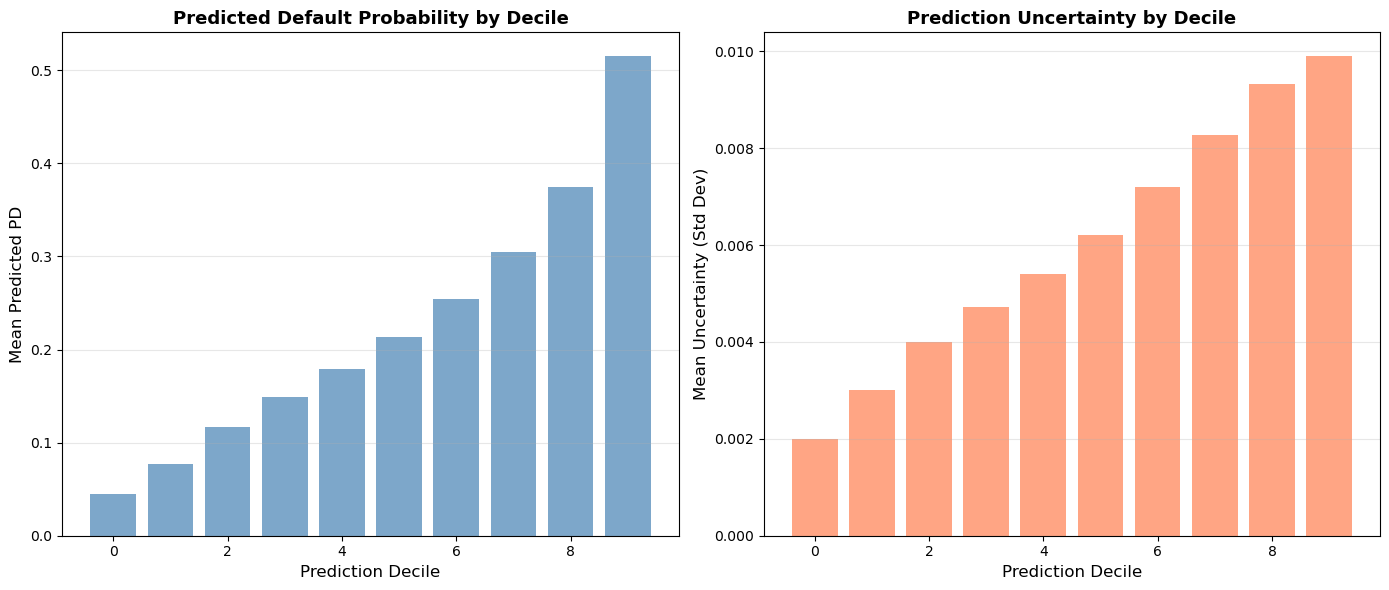

Uncertainty plot saved


In [8]:
df_uncertainty['decile'] = pd.qcut(df_uncertainty['pred_mean'], q=10, labels=False, duplicates='drop')

decile_stats = df_uncertainty.groupby('decile').agg(
    count=('pred_mean', 'count'),
    mean_pred=('pred_mean', 'mean'),
    mean_std=('pred_std', 'mean'),
    mean_interval=('pred_upper', lambda x: (df_uncertainty.loc[x.index, 'pred_upper'] - 
                                             df_uncertainty.loc[x.index, 'pred_lower']).mean())
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(range(len(decile_stats)), decile_stats['mean_pred'], alpha=0.7, color='steelblue')
axes[0].set_xlabel('Prediction Decile', fontsize=12)
axes[0].set_ylabel('Mean Predicted PD', fontsize=12)
axes[0].set_title('Predicted Default Probability by Decile', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(len(decile_stats)), decile_stats['mean_std'], alpha=0.7, color='coral')
axes[1].set_xlabel('Prediction Decile', fontsize=12)
axes[1].set_ylabel('Mean Uncertainty (Std Dev)', fontsize=12)
axes[1].set_title('Prediction Uncertainty by Decile', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/bayesian_uncertainty_by_decile.png', dpi=300, bbox_inches='tight')
plt.show()

print("Uncertainty plot saved")

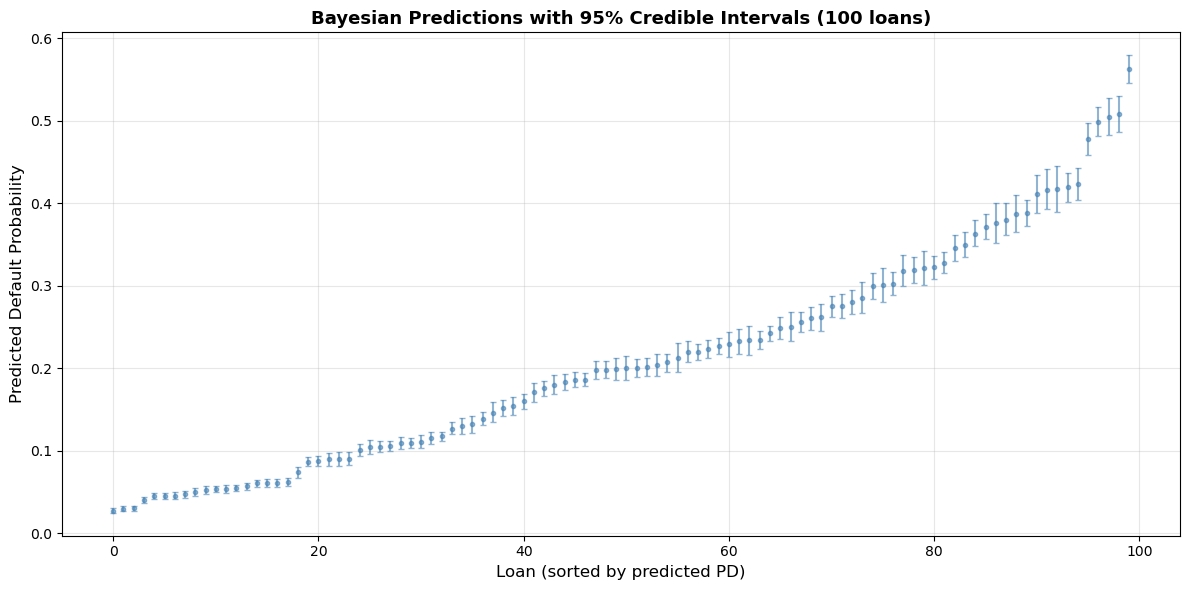

Credible intervals plot saved


In [9]:
sample_loans = np.random.choice(len(df_uncertainty), size=100, replace=False)
sample_loans = sorted(sample_loans, key=lambda x: df_uncertainty.iloc[x]['pred_mean'])

fig, ax = plt.subplots(figsize=(12, 6))

x_pos = range(len(sample_loans))
means = [df_uncertainty.iloc[i]['pred_mean'] for i in sample_loans]
lowers = [df_uncertainty.iloc[i]['pred_lower'] for i in sample_loans]
uppers = [df_uncertainty.iloc[i]['pred_upper'] for i in sample_loans]
errors_lower = [means[j] - lowers[j] for j in range(len(means))]
errors_upper = [uppers[j] - means[j] for j in range(len(means))]

ax.errorbar(x_pos, means, yerr=[errors_lower, errors_upper], 
            fmt='o', markersize=3, capsize=2, alpha=0.6, color='steelblue')

ax.set_xlabel('Loan (sorted by predicted PD)', fontsize=12)
ax.set_ylabel('Predicted Default Probability', fontsize=12)
ax.set_title('Bayesian Predictions with 95% Credible Intervals (100 loans)', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/bayesian_credible_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

print("Credible intervals plot saved")

In [10]:
import pickle
import os

os.makedirs('./../models', exist_ok=True)

with open('./../models/bayesian_trace.pkl', 'wb') as f:
    pickle.dump(trace, f)

print("Bayesian trace saved")

bayesian_summary = f"""
BAYESIAN LOGISTIC REGRESSION - UNCERTAINTY QUANTIFICATION
==========================================================

Model Configuration:
  Training sample: 50,000 loans (7.5% of full training set)
  MCMC samples: 2,000 per chain (2 chains)
  Convergence: Excellent (all R-hat = 1.0)

Performance (Validation Set):
  AUC: {auc_bayesian:.4f}
  Gini: {gini_bayesian:.4f}
  (Comparable to frequentist logistic regression)

Uncertainty Quantification:
  Mean prediction: {pred_mean.mean():.2%}
  Mean std dev: {pred_std.mean():.4f}
  Mean 95% interval width: {(pred_upper - pred_lower).mean():.4f}

Key Insight:
  Higher-risk predictions have higher uncertainty
  - Low-risk decile: {decile_stats.iloc[0]['mean_std']:.4f} std dev
  - High-risk decile: {decile_stats.iloc[-1]['mean_std']:.4f} std dev
  
Business Value:
  Risk managers can identify borderline cases with high uncertainty
  where manual review provides most value

Status: Bayesian model ready for uncertainty-aware decision making
"""

print(bayesian_summary)

with open('./../reports/bayesian_model_summary.txt', 'w') as f:
    f.write(bayesian_summary)

print("\nBayesian summary saved")

Bayesian trace saved

BAYESIAN LOGISTIC REGRESSION - UNCERTAINTY QUANTIFICATION

Model Configuration:
  Training sample: 50,000 loans (7.5% of full training set)
  MCMC samples: 2,000 per chain (2 chains)
  Convergence: Excellent (all R-hat = 1.0)

Performance (Validation Set):
  AUC: 0.6966
  Gini: 0.3933
  (Comparable to frequentist logistic regression)

Uncertainty Quantification:
  Mean prediction: 22.29%
  Mean std dev: 0.0060
  Mean 95% interval width: 0.0235

Key Insight:
  Higher-risk predictions have higher uncertainty
  - Low-risk decile: 0.0020 std dev
  - High-risk decile: 0.0099 std dev

Business Value:
  Risk managers can identify borderline cases with high uncertainty
  where manual review provides most value

Status: Bayesian model ready for uncertainty-aware decision making


Bayesian summary saved
